## Análisis exploratorio sobre los datos de WIDS 2024


## Competition Overview
The Women in Data Science (WiDS) Datathon 2024 Challenge 1 focuses on **equity in healthcare AI**, specifically addressing demographic parity in medical diagnosis predictions.

## Problem Statement
Develop machine learning models that can predict medical diagnoses while ensuring **equitable performance across different demographic groups**. The challenge emphasizes creating AI systems that work fairly for all patients regardless of their demographic characteristics.

## Dataset Description

### Files Available
- **training.csv** (11.3 MB) - Training dataset with features and target labels
- **test.csv** (5.0 MB) - Test dataset for final predictions  
- **sample_submission.csv** (69.5 KB) - Example submission format

### Key Features
The dataset contains medical and demographic information including:
- **Medical indicators**: Various health metrics and diagnostic measurements
- **Demographic variables**: Age, gender, ethnicity, and other demographic factors
- **Target variable**: Medical diagnosis outcome (binary classification)

## Evaluation Criteria
Models are evaluated on:
1. **Overall predictive accuracy**
2. **Demographic parity**: Ensuring equal performance across demographic groups
3. **Fairness metrics**: Measuring bias and equity in predictions

## Challenge Focus
This competition specifically addresses the critical issue of **algorithmic bias in healthcare AI**, encouraging participants to develop models that are both accurate and equitable across diverse patient populations.

## Data Ethics
Participants must consider:
- Patient privacy and data protection
- Bias mitigation techniques
- Fairness-aware machine learning approaches
- Responsible AI development practices

---
*Source: [Kaggle WIDS Datathon 2024 Challenge 1](https://www.kaggle.com/competitions/widsdatathon2024-challenge1/data)*


In [ ]:
## Importacion de librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, accuracy_score, roc_auc_score, ConfusionMatrixDisplay
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score

In [2]:
## Cargar datos
df_training = pd.read_csv('../data/training.csv')
df_test = pd.read_csv('../data/test.csv')

## Quitar columnas irrelevantes
df_training.drop(columns=['patient_id','breast_cancer_diagnosis_desc','metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type'], inplace=True)
df_test.drop(columns=['patient_id','breast_cancer_diagnosis_desc','metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type'], inplace=True)

df_training.head()

,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code,Region,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
0,NaN,MEDICAID,CA,924,84,F,NaN,C50919,C7989,West,...,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,1
1,White,COMMERCIAL,CA,928,62,F,28.49,C50411,C773,West,...,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,1
2,White,COMMERCIAL,TX,760,43,F,38.09,C50112,C773,South,...,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,1
3,White,COMMERCIAL,CA,926,45,F,NaN,C50212,C773,West,...,8.845238,8.688095,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123,0
4,NaN,COMMERCIAL,ID,836,55,F,NaN,1749,C773,West,...,15.276000,11.224000,1.946000,26.170213,12.088000,13.106000,41.356058,4.110749,11.722197,0


In [3]:
# informacion del dataset
df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12906 entries, 0 to 12905
Data columns (total 79 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   patient_race                      6521 non-null   object 
 1   payer_type                        11103 non-null  object 
 2   patient_state                     12855 non-null  object 
 3   patient_zip3                      12906 non-null  int64  
 4   patient_age                       12906 non-null  int64  
 5   patient_gender                    12906 non-null  object 
 6   bmi                               3941 non-null   float64
 7   breast_cancer_diagnosis_code      12906 non-null  object 
 8   metastatic_cancer_diagnosis_code  12906 non-null  object 
 9   Region                            12854 non-null  object 
 10  Division                          12854 non-null  object 
 11  population                        12905 non-null  float64
 12  dens

In [4]:
# porcentaje de valores nulos por columna
null_percentage = (round(df_training.isnull().mean()*100,2)).to_frame(name='Porcentaje de valores nulos').sort_values(by='Porcentaje de valores nulos', ascending=False)
display(null_percentage.head(20))

,Porcentaje de valores nulos
bmi,69.46
patient_race,49.47
payer_type,13.97
Division,0.40
Region,0.40
patient_state,0.40
Ozone,0.22
PM25,0.22
N02,0.22
income_household_under_5,0.03


## Variable: BMI

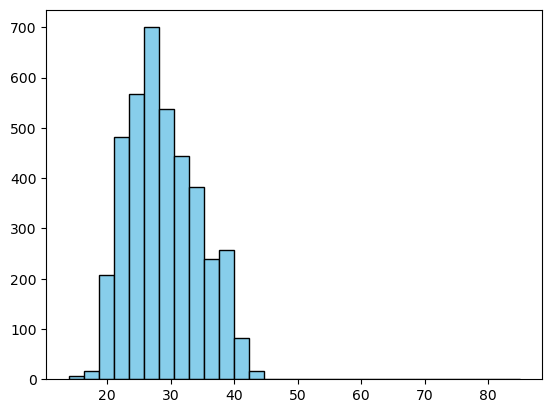

In [5]:
plt.hist(df_training['bmi'], bins=30, color='skyblue', edgecolor='black')
plt.show()

<Axes: xlabel='bmi', ylabel='Density'>

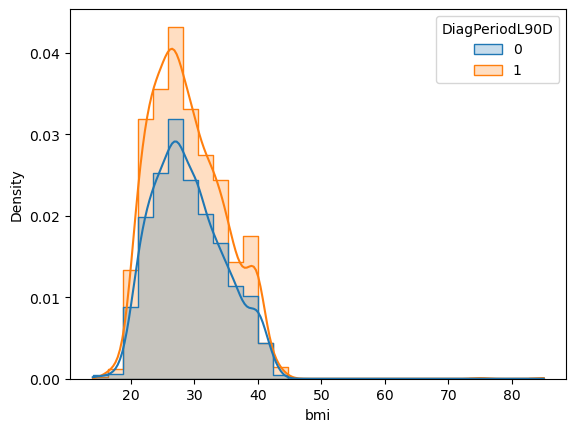

In [6]:
sns.histplot(data=df_training, x='bmi', hue='DiagPeriodL90D', bins=30, kde=True, element='step', stat='density')

In [7]:
## Clasificacion de bmi
df_training['bmi_category'] = pd.cut(df_training['bmi'], bins=[0, 18.5, 24.9, 29.9, 34.9,39.9, np.inf], labels=['Underweight', 'Normal', 'Overweight', 'Obesity I', 'Obesity II','Extreme']).astype(object)
df_test['bmi_category'] = pd.cut(df_test['bmi'], bins=[0, 18.5, 24.9, 29.9, 34.9,39.9, np.inf], labels=['Underweight', 'Normal', 'Overweight', 'Obesity I', 'Obesity II','Extreme']).astype(object)
df_training['bmi_category'] = df_training['bmi_category'].fillna('Unknown')
df_test['bmi_category'] = df_test['bmi_category'].fillna('Unknown')

In [8]:
df_training.drop(columns=['bmi'], inplace=True)
df_test.drop(columns=['bmi'], inplace=True)

In [9]:
pd.crosstab(df_training['bmi_category'], df_training['DiagPeriodL90D'], normalize='index', margins=True)

DiagPeriodL90D,0,1
bmi_category,,
Extreme,0.410256,0.589744
Normal,0.399600,0.600400
Obesity I,0.430752,0.569248
Obesity II,0.406316,0.593684
Overweight,0.412472,0.587528
Underweight,0.409091,0.590909
Unknown,0.359175,0.640825
All,0.375484,0.624516


In [10]:
df_training['DiagPeriodL90D'].value_counts(normalize=True)

DiagPeriodL90D
1    0.624516
0    0.375484
Name: proportion, dtype: float64

In [11]:
null_percentage = (round(df_training.isnull().mean()*100,2)).to_frame(name='Porcentaje de valores nulos').sort_values(by='Porcentaje de valores nulos', ascending=False)
display(null_percentage.head(20))

,Porcentaje de valores nulos
patient_race,49.47
payer_type,13.97
patient_state,0.40
Division,0.40
Region,0.40
N02,0.22
PM25,0.22
Ozone,0.22
income_household_under_5,0.03
income_household_5_to_10,0.03


In [12]:
df_training['patient_race'] = df_training['patient_race'].fillna('Unknown')
df_test['patient_race'] = df_test['patient_race'].fillna('Unknown')

In [13]:
df_training['patient_race'].value_counts(normalize=True)

patient_race
Unknown     0.494731
White       0.278010
Black       0.081822
Hispanic    0.064234
Other       0.052921
Asian       0.028281
Name: proportion, dtype: float64

In [14]:
null_percentage = (round(df_training.isnull().mean()*100,2)).to_frame(name='Porcentaje de valores nulos').sort_values(by='Porcentaje de valores nulos', ascending=False)
display(null_percentage.head(20))

,Porcentaje de valores nulos
payer_type,13.97
Region,0.40
patient_state,0.40
Division,0.40
N02,0.22
PM25,0.22
Ozone,0.22
income_household_15_to_20,0.03
income_household_50_to_75,0.03
income_household_35_to_50,0.03


In [15]:
df_training['payer_type'] = df_training['payer_type'].fillna('No insurance')
df_test['payer_type'] = df_test['payer_type'].fillna('No insurance')

In [16]:
df_training['payer_type'].value_counts(normalize=True)

payer_type
COMMERCIAL            0.467380
MEDICAID              0.199055
MEDICARE ADVANTAGE    0.193863
No insurance          0.139702
Name: proportion, dtype: float64

In [17]:
null_percentage = (round(df_training.isnull().mean()*100,2)).to_frame(name='Porcentaje de valores nulos').sort_values(by='Porcentaje de valores nulos', ascending=False)
display(null_percentage.head(20))

,Porcentaje de valores nulos
patient_state,0.40
Region,0.40
Division,0.40
N02,0.22
PM25,0.22
Ozone,0.22
income_household_75_to_100,0.03
income_household_100_to_150,0.03
income_household_median,0.03
income_household_under_5,0.03


In [18]:
df_training = df_training.dropna()

## Rellenar valores nulos en dataset test

In [43]:
test_categories = df_test.select_dtypes(include=['object']).columns.tolist()
test_numeric = df_test.select_dtypes(include=['number']).columns.tolist()

In [47]:
num_imputer = SimpleImputer(strategy='mean')
df_test[test_numeric] = num_imputer.fit_transform(df_test[test_numeric])
cat_imputer = SimpleImputer(strategy='most_frequent')
df_test[test_categories] = cat_imputer.fit_transform(df_test[test_categories])

In [48]:
test_numeric

['patient_zip3',
 'patient_age',
 'population',
 'density',
 'age_median',
 'age_under_10',
 'age_10_to_19',
 'age_20s',
 'age_30s',
 'age_40s',
 'age_50s',
 'age_60s',
 'age_70s',
 'age_over_80',
 'male',
 'female',
 'married',
 'divorced',
 'never_married',
 'widowed',
 'family_size',
 'family_dual_income',
 'income_household_median',
 'income_household_under_5',
 'income_household_5_to_10',
 'income_household_10_to_15',
 'income_household_15_to_20',
 'income_household_20_to_25',
 'income_household_25_to_35',
 'income_household_35_to_50',
 'income_household_50_to_75',
 'income_household_75_to_100',
 'income_household_100_to_150',
 'income_household_150_over',
 'income_household_six_figure',
 'income_individual_median',
 'home_ownership',
 'housing_units',
 'home_value',
 'rent_median',
 'rent_burden',
 'education_less_highschool',
 'education_highschool',
 'education_some_college',
 'education_bachelors',
 'education_graduate',
 'education_college_or_above',
 'education_stem_degree',

In [49]:
test_categories

['patient_race',
 'payer_type',
 'patient_state',
 'patient_gender',
 'breast_cancer_diagnosis_code',
 'metastatic_cancer_diagnosis_code',
 'Region',
 'Division',
 'bmi_category']

In [50]:
null_percentage = (round(df_test.isnull().mean()*100,2)).to_frame(name='Porcentaje de valores nulos').sort_values(by='Porcentaje de valores nulos', ascending=False)
display(null_percentage.head(20))

,Porcentaje de valores nulos
patient_race,0.0
education_less_highschool,0.0
labor_force_participation,0.0
education_stem_degree,0.0
education_college_or_above,0.0
education_graduate,0.0
education_bachelors,0.0
education_some_college,0.0
education_highschool,0.0
rent_burden,0.0


## Codificación de variables categoricas

In [24]:
training_categories = df_training.select_dtypes(include=['object']).columns.tolist()
training_numeric = df_training.select_dtypes(include=['number']).columns.tolist()

In [25]:
df_training_encoded = pd.get_dummies(df_training, columns=training_categories, drop_first=False, dtype=int)
df_training_encoded.head()

,patient_zip3,patient_age,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,...,Division_South Atlantic,Division_West North Central,Division_West South Central,bmi_category_Extreme,bmi_category_Normal,bmi_category_Obesity I,bmi_category_Obesity II,bmi_category_Overweight,bmi_category_Underweight,bmi_category_Unknown
0,924,84,31437.75000,1189.562500,30.642857,16.014286,15.542857,17.614286,14.014286,11.614286,...,0,0,0,0,0,0,0,0,0,1
1,928,62,39121.87879,2295.939394,38.200000,11.878788,13.354545,14.230303,13.418182,13.333333,...,0,0,0,0,0,0,0,1,0,0
2,760,43,21996.68333,626.236667,37.906667,13.028333,14.463333,12.531667,13.545000,12.860000,...,0,0,1,0,0,0,1,0,0,0
3,926,45,32795.32558,1896.220930,42.871429,10.071429,12.135714,12.538095,12.464286,12.650000,...,0,0,0,0,0,0,0,0,0,1
4,836,55,10886.26000,116.886000,43.473469,10.824000,13.976000,9.492000,10.364000,12.600000,...,0,0,0,0,0,0,0,0,0,1


In [54]:
df_test_encoded = pd.get_dummies(df_test, columns=training_categories, drop_first=False, dtype=int)

In [26]:
df_training_encoded.shape

(12822, 241)

## Modelos ML

In [27]:
X = df_training_encoded.drop(columns=['DiagPeriodL90D'])
y = df_training_encoded['DiagPeriodL90D']

In [28]:
# split de datos de entrenamiento y datos de validacion

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    train_size=0.8, 
                                                    stratify=y,
                                                    random_state=10)
print("Train size: {}".format(len(y_train)))
print("Test size: {}".format(len(y_test)))

Train size: 10257
Test size: 2565


In [29]:
# Entrenamiento de varios modelos ML
random_state  = 13


clf_keys = ["Logistic Regression", "Naive Bayes", "k-Nearest Neighbors",
            "Decision Tree"]
clf_values = [LogisticRegression(random_state=random_state, max_iter=10000),
              #SVC(kernel="linear", random_state=random_state),
              GaussianNB(),
              KNeighborsClassifier(),
              DecisionTreeClassifier(random_state=random_state, min_samples_split=50,min_samples_leaf=20)]


clfs = dict(zip(clf_keys, clf_values))

# Dataset original
print("Entrenamiento del modelo utilizando dataset original: comienza!")
for clf_name, clf in clfs.items():
    clf.fit(X_train, y_train)
    clfs[clf_name] = clf
    print(clf_name, ", entrenamiento: completado!")
print("Entrenamiento del modelo utilizando dataset original: termina!\n")

Entrenamiento del modelo utilizando dataset original: comienza!


/Users/vanotole/anaconda3/envs/tsi_ml_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression , entrenamiento: completado!
Naive Bayes , entrenamiento: completado!
k-Nearest Neighbors , entrenamiento: completado!
Decision Tree , entrenamiento: completado!
Entrenamiento del modelo utilizando dataset original: termina!



In [32]:
# Dataset original
acc = []
for clf_name, clf in clfs.items():
    y_pred = clf.predict(X_test)
    acc.append(accuracy_score(y_test, y_pred))

acc_all = pd.DataFrame({"Original dataset": acc},
                       index=clf_keys)
acc_all

,Original dataset
Logistic Regression,0.623782
Naive Bayes,0.598441
k-Nearest Neighbors,0.568421
Decision Tree,0.784405


In [34]:
scoring = ["accuracy", "roc_auc"]
random_state=10

scores = []
# Original dataset
print("Validación cruzada sobre los datos originales: comienza!")
for clf_name, clf in clfs.items():
    score = pd.DataFrame(cross_validate(clf, X, y, cv=StratifiedKFold(3, random_state=random_state, shuffle=True), scoring=scoring)).mean()
    scores.append(score)
    print(clf_name, "validación cruzada: termina!")
cv_scores = pd.concat(scores, axis=1).rename(columns=dict(zip(range(len(clf_keys)), clf_keys)))
print("Validación cruzada sobre los datos originales: termina!\n")

Validación cruzada sobre los datos originales: comienza!


/Users/vanotole/anaconda3/envs/tsi_ml_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vanotole/anaconda3/envs/tsi_ml_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

Logistic Regression validación cruzada: termina!
Naive Bayes validación cruzada: termina!
k-Nearest Neighbors validación cruzada: termina!
Decision Tree validación cruzada: termina!
Validación cruzada sobre los datos originales: termina!



Cross-validation accuracy
Original data    0.643289


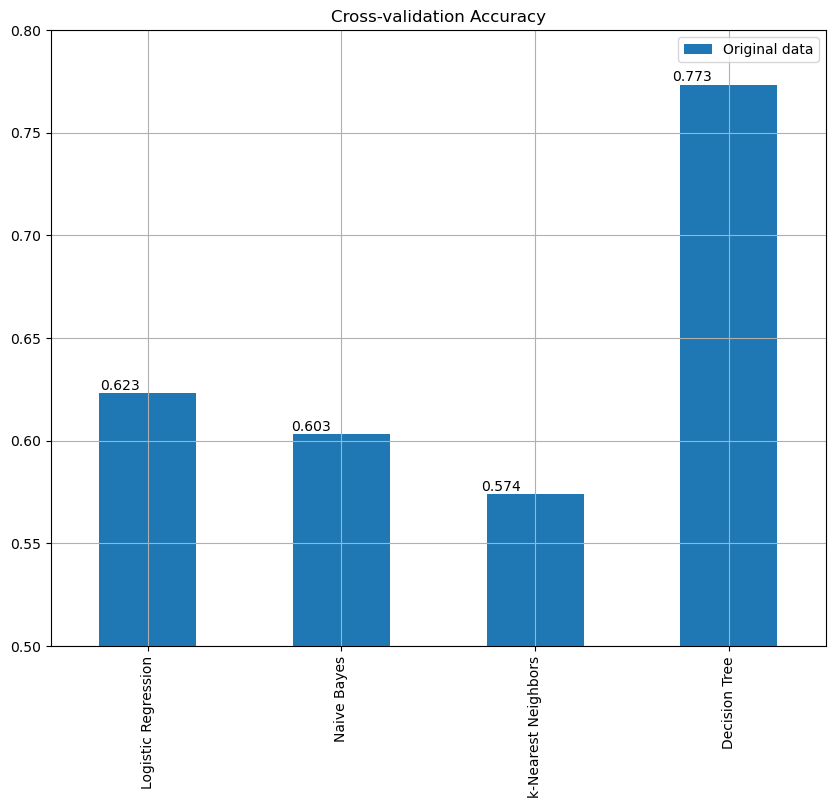

In [38]:
cv_acc_all = pd.concat([cv_scores.loc["test_accuracy"].rename("Original data")], 
                       axis=1)

print("Cross-validation accuracy\n" + cv_acc_all.mean().to_string())
ax = cv_acc_all.plot.bar(figsize=(10, 8))
for p in ax.patches:
    ax.annotate(str(p.get_height().round(3)), (p.get_x()*0.985, p.get_height()*1.003))
plt.xticks(rotation=90)
plt.ylim((0.5, 0.8))
plt.title("Cross-validation Accuracy")
plt.grid()
plt.legend()
plt.show()

Cross-validation ROC AUC score
Original data    0.604137


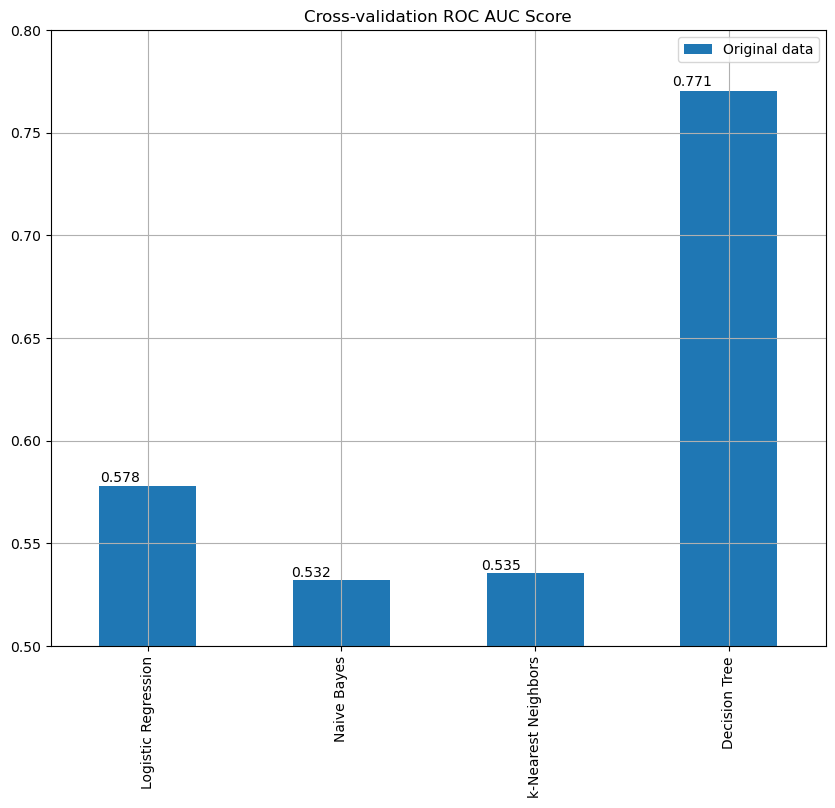

In [41]:
cv_roc_auc_all = pd.concat([cv_scores.loc["test_roc_auc"].rename("Original data")], 
                           axis=1)

print("Cross-validation ROC AUC score\n" + cv_roc_auc_all.mean().to_string())
ax = cv_roc_auc_all.plot.bar(figsize=(10, 8))
for p in ax.patches:
    ax.annotate(str(p.get_height().round(3)), (p.get_x()*0.985, p.get_height()*1.003))
plt.xticks(rotation=90)
plt.ylim((0.5, 0.8))
plt.title("Cross-validation ROC AUC Score")
plt.grid()
plt.legend()
plt.show()

Cross-validation fit time
Original data    6.571424


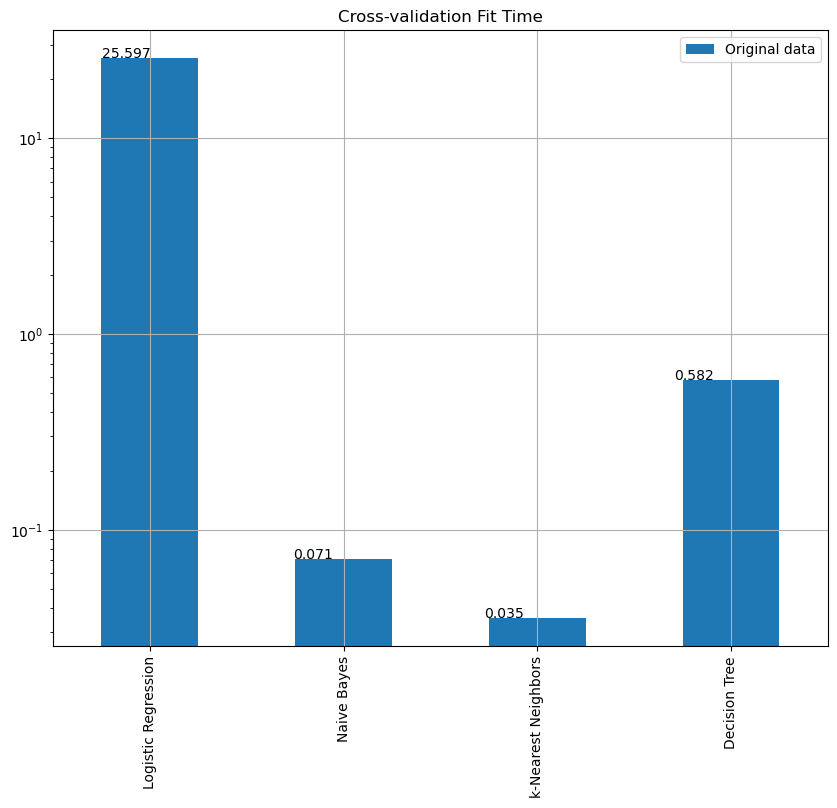

In [42]:
# Fit time
cv_fit_time_all = pd.concat([cv_scores.loc["fit_time"].rename("Original data")], 
                           axis=1)

print("Cross-validation fit time\n" + cv_fit_time_all.mean().to_string())
ax = cv_fit_time_all.plot.bar(figsize=(10, 8))
for p in ax.patches:
    ax.annotate(str(p.get_height().round(3)), (p.get_x()*0.985, p.get_height()*1.003))
plt.xticks(rotation=90)
plt.yscale("log")
plt.title("Cross-validation Fit Time")
plt.grid()
plt.legend()
plt.show()

In [56]:
clfs['Decision Tree'].predict(df_test_encoded)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- breast_cancer_diagnosis_code_C50921
- breast_cancer_diagnosis_code_C50922
- patient_state_AK
- patient_state_HI
Feature names seen at fit time, yet now missing:
- breast_cancer_diagnosis_code_1759
- breast_cancer_diagnosis_code_C50
- breast_cancer_diagnosis_code_C5001
- breast_cancer_diagnosis_code_C50021
- breast_cancer_diagnosis_code_C5011
- ...
